<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session8/session_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 2), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 3.8MB/s 
     |████████████████████████████████| 38.2MB 73kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *

In [ ]:
from vision_pytorch.gradcam import GradCAM

In [14]:
import importlib
importlib.reload(vision_pytorch.utils)
# importlib.reload(resnet)

<module 'vision_pytorch.utils' from '/content/vision_pytorch/utils.py'>

In [2]:
trainset, testset = download_data()

Files already downloaded and verified
Files already downloaded and verified


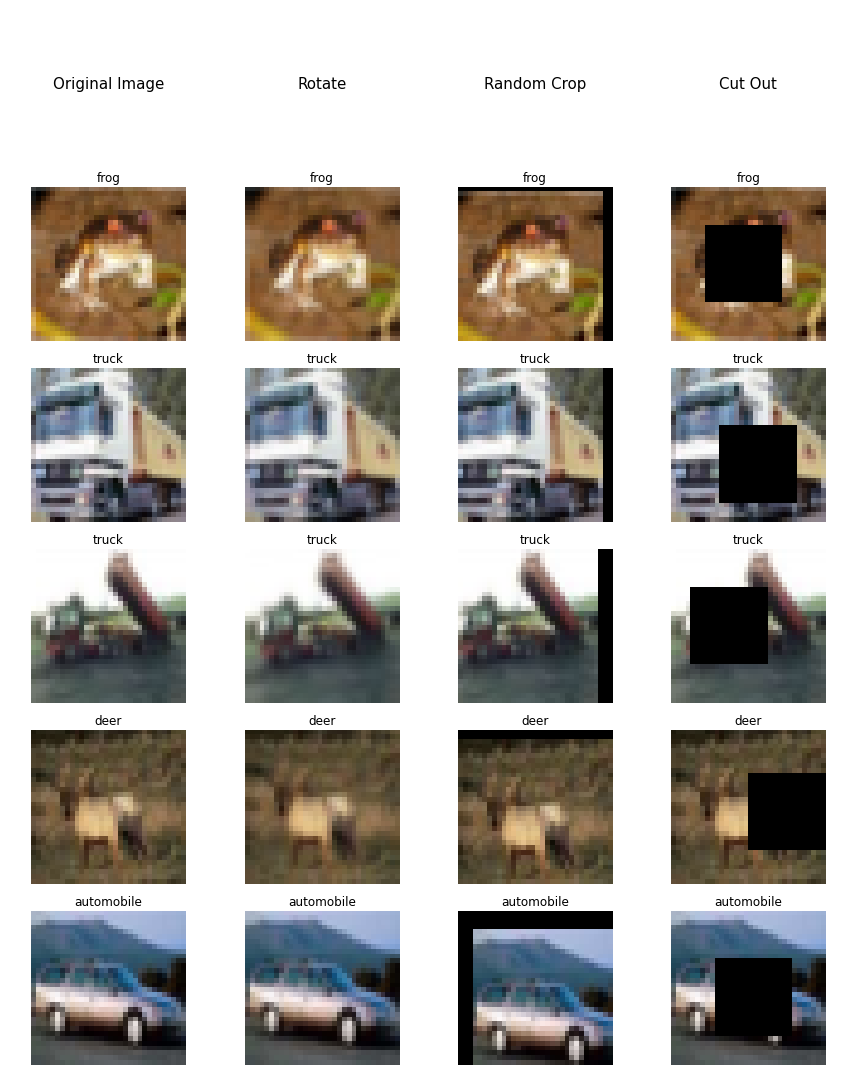

In [3]:
plot_aug({
    'Original Image': None,
    'Rotate': A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=True, p=0.5),
    
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True)
}, data=trainset)

In [4]:
# Apply these transforms while training:
# RandomCrop(32, padding=4)
# CutOut(16x16)
# Rotate(±5°)

train_transform = A.Compose({
  A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
  A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
  A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
})

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [5]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=32

CUDA Available: True


In [6]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [8]:
net_18 = resnet.ResNet18().to(device)
summary(net_18, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

In [ ]:
optimizer = torch.optim.SGD(net_18.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min', patience=8, verbose=True)

net_18, history_18 = fit_model(
    net=net_18,
    train_loader=train_loader, test_loader=test_loader,
    scheduler=scheduler, 
    optimizer=optimizer, device=device, NUM_EPOCHS=20
)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8089, Accuracy: 3064/10000 (30.64%)

EPOCH: 2


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7614, Accuracy: 3656/10000 (36.56%)

EPOCH: 3


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4766, Accuracy: 4463/10000 (44.63%)

EPOCH: 4


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3111, Accuracy: 5170/10000 (51.70%)

EPOCH: 5


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2495, Accuracy: 5361/10000 (53.61%)

EPOCH: 6


Batch_id=15 Loss=1.40287 Accuracy=47.95:   2%|▏         | 16/782 [00:02<02:03,  6.20it/s]

In [ ]:
torch.save(net_18.state_dict(), "resnet18.pt")

Plot the accuracy and loss curves

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history_18[1], label='Train')
axs[0].plot(history_18[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history_18[0], label='Train')
axs[1].plot(history_18[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

Load the saved model

In [ ]:
net_18.load_state_dict(torch.load("resnet18.pt"))

In [ ]:
summary(net_18,input_size = (3,32,32))

In [ ]:
net_18.eval()

In [ ]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
images, labels = plot_misclassified(net_18, test_loader, testset.classes, device, mean, std, return_misclf=True)

#Load the model


In [ ]:
# net_18 = resnet.ResNet18().to(device)
# summary(net_18, input_size=(3, 32, 32))

In [ ]:
# net_18.load_state_dict(torch.load("resnet18.pt"))

# Understanding Gradcam

In [ ]:
inputs = torch.stack(images, dim=0)
target = torch.tensor(labels)

In [ ]:
gcam = GradCAM(net_18.layer4[1])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

net_18 = net_18.cpu()
out = net_18(inputs)
print(out.size())
err = loss_fn(out, target)
err.backward()

In [ ]:
gcam.remove_hooks()

In [ ]:
rows, cols = int(inputs.shape[0]/5),5
figure = plt.figure(figsize=(cols*3,rows*3))
for i in range(1, cols * rows + 1):
    # img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    # plt.title(f"Pred label: {classes[pred]}\n True label: {classes[label]}") # title of plot
    plt.axis("off") # hiding the axis
    img = gcam.generate(inputs, inputs.shape[2:], i-1)
    plt.imshow(img.squeeze(), cmap="rainbow") # showing the plot

plt.tight_layout()
plt.show()

# Experiments to be deleted

In [80]:
# gcam_obj = gcam
index = 0
input_shape = inputs.shape[2:]
input_image = inputs[idx]

In [119]:
input_image = np.transpose(input_image, (1,2,0))
input_image.shape

In [89]:
import matplotlib.cm as cm

In [97]:
grad = gcam_obj.grad[index].unsqueeze(dim=0)
print(grad.shape)

fmap = gcam_obj.fmap[index].unsqueeze(dim=0)

weights = F.adaptive_avg_pool2d(grad, 1)
print(weights.shape)

gcam = torch.mul(fmap, weights).sum(dim=1, keepdim=True)
print(gcam.shape)
gcam = F.relu(gcam)
gcam = F.interpolate(
    gcam, input_shape, mode="bilinear", align_corners=False
)

# print(gcam.shape)
B, C, H, W = gcam.shape
gcam = gcam.view(B, -1)
gcam -= gcam.min(dim=1, keepdim=True)[0]
gcam /= gcam.max(dim=1, keepdim=True)[0]
gcam = gcam.view(B, C, H, W)

# get the heatmap
gcam = gcam.numpy()
print(input_image.shape)
input_image = input_image.numpy()
cmap = cm.jet_r(gcam)[..., :3] * 255.0
gcam_image = (cmap.astype(np.float) + input_image.astype(np.float)) / 2

# return gcam_image

torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 1, 1])
torch.Size([1, 1, 8, 8])


In [44]:
inputs.shape[0]

20

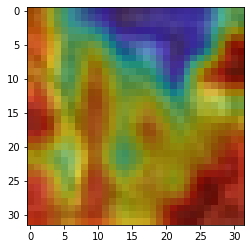

In [43]:
plt.imshow(gcam_image.squeeze(), cmap='rainbow')

In [141]:
# gcam = gcam.numpy()
# print(input_image.shape)
# input_image = input_image.numpy()
cmap = cm.jet_r(gcam)[..., :3] #* 255.0
gcam_image = (cmap.astype(np.float) + input_image2.astype(np.float)) / 2

In [111]:
gcam_image = cmap.astype(np.float)

In [98]:
print(gcam.shape)

torch.Size([1, 1, 32, 32])


In [99]:
gcam_back = gcam

In [100]:
B, C, H, W = gcam.shape
gcam = gcam.view(B, -1)
gcam -= gcam.min(dim=1, keepdim=True)[0]
gcam /= gcam.max(dim=1, keepdim=True)[0]
gcam = gcam.view(B, C, H, W)

In [107]:
gcam2 = gcam.squeeze()

In [108]:
gcam2.shape

torch.Size([32, 32])

In [ ]:
gcam_image = gcam.generate(inputs[0], inputs.shape[2:], 0)

In [ ]:
raw_image = cv2.imread('1915.jpg')
raw_image = cv2.resize(raw_image, (32,) * 2)
image = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)(raw_image[..., ::-1].copy())


In [ ]:

def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    global map
    map = output.detach()
    print(map)
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())

def printgradnorm(self, grad_input, grad_output):
    global grad
    grad = grad_output[0].detach()
    print('Inside ' + self.__class__.__name__ + ' backward')
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input: ', type(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())




handle_fw = net_18.layer4[1].register_forward_hook(printnorm)
handle_bw = net_18.layer4[1].register_backward_hook(printgradnorm)
net_18 = net_18.cpu()
out = net_18(input)
print(out.size())
err = loss_fn(out, target)
err.backward()

# handle_fw.remove()
# handle_bw.remove()

In [ ]:
image_shape = input.shape[2:]

In [ ]:
grad

In [ ]:
# def generate(self, target_layer):
    # fmaps = self._find(self.fmap_pool, target_layer)
    # grads = self._find(self.grad_pool, target_layer)
weights = F.adaptive_avg_pool2d(grad, 1)
print(weights.shape)

gcam = torch.mul(map, weights).sum(dim=1, keepdim=True)
print(weights.shape)
gcam = F.relu(gcam)
gcam = F.interpolate(
    gcam, image_shape, mode="bilinear", align_corners=False
)

B, C, H, W = gcam.shape
gcam = gcam.view(B, -1)
gcam -= gcam.min(dim=1, keepdim=True)[0]
gcam /= gcam.max(dim=1, keepdim=True)[0]
gcam = gcam.view(B, C, H, W)

In [ ]:
gcam.shape

In [ ]:
# gcam = alpha * cmap + (1 - alpha) * raw_image

In [ ]:
import matplotlib.cm as cm

In [ ]:
gcam = gcam.numpy()
cmap = cm.jet_r(gcam)[..., :3] * 255.0
# cmap = cm.jet_r(gcam)[..., :3] * 255.0

In [ ]:
gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2

In [ ]:
alpha.shape

In [ ]:
cmap.shape

In [123]:
gcam_image = gcam.squeeze()

In [144]:
g = gcam_image.squeeze()

In [ ]:
g

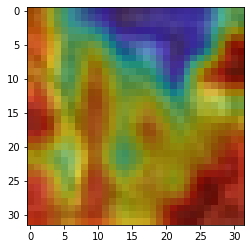

In [145]:
plt.imshow((g), cmap='rainbow')

In [ ]:
out

In [ ]:
target.view_as(out)

In [166]:
class GradCAM2():
    def __init__(self, model_layer):
        self.fmap = None
        self.grad = None
        #Register the forward and backward hooks
        

        handle_fw = model_layer.register_forward_hook(self.fwd_hook)
        handle_bw = model_layer.register_backward_hook(self.bkw_hook)
        self.handles = [handle_fw, handle_bw]
    
    def fwd_hook(self, module, input, output):
        print(module)
        self.fmap = output.detach()
        print('Inside ' + self.__class__.__name__ + ' forward')
        print('')
        print('input: ', type(input))
        print('input[0]: ', type(input[0]))
        print('output: ', type(output))
        print('')
        print('input size:', input[0].size())
        print('output size:', output.data.size())
        print('output norm:', output.data.norm())

    def bkw_hook(self, module, grad_input, grad_output):
        self.grad = grad_output[0].detach()
        print('Inside ' + self.__class__.__name__ + ' backward')
        print('')
        print('grad_input: ', type(grad_input))
        print('grad_input[0]: ', type(grad_input[0]))
        print('grad_output: ', type(grad_output))
        print('grad_output[0]: ', type(grad_output[0]))
        print('')
        print('grad_input size:', grad_input[0].size())
        print('grad_output size:', grad_output[0].size())
        print('grad_input norm:', grad_input[0].norm())
        print(self.grad.shape)

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def generate(self, input_image, input_shape):
        weights = F.adaptive_avg_pool2d(self.grad, 1)
        print(weights.shape)

        gcam = torch.mul(self.fmap, weights).sum(dim=1, keepdim=True)
        print(weights.shape)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        #get the heatmap
        gcam = gcam.numpy()
        cmap = cm.jet_r(gcam)[..., :3] * 255.0
        gcam_image = (cmap.astype(np.float) + input_image.astype(np.float)) / 2

        return gcam_image